In [1]:
pip install pandas scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from urllib.parse import urlparse
import numpy as np
from math import log2

In [22]:
import matplotlib.pyplot as plt

In [3]:
# Calculate entropy of a string
def string_entropy(s):
    """Calculate the entropy of a string."""
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    entropy = - sum([p * log2(p) for p in prob])
    return entropy

# Feature extraction function including entropy
def extract_features(df):
    def get_features(url):
        parsed_url = urlparse(url)
        return {
            'length': len(url),
            'is_https': 1 if parsed_url.scheme == 'https' else 0,
            'num_special_chars': sum([1 for i in url if not i.isalnum()]),
            'num_subdomains': url.count('.'),
            'entropy': string_entropy(url),
            # Add more features as needed
        }
    
    features = df['url'].apply(lambda url: pd.Series(get_features(url)))
    return pd.concat([df, features], axis=1)






In [18]:
df = pd.read_csv('combined_df.csv')

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df_features = extract_features(df)

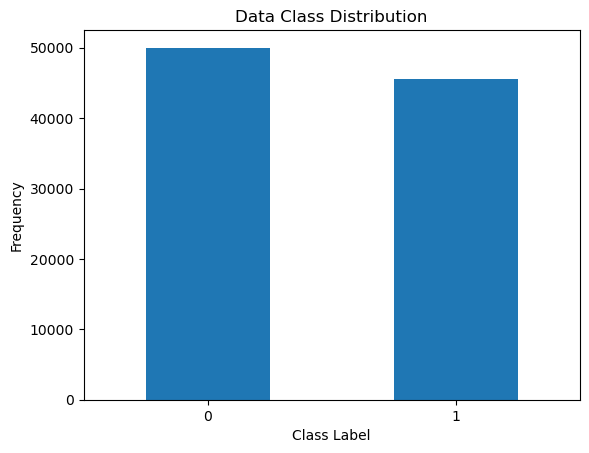

In [23]:
# Assuming df is your DataFrame and it contains a 'label' column
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Create a bar plot
label_counts.plot(kind='bar')
plt.title('Data Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the labels on the x-axis vertical for readability
plt.show()

In [24]:
X = df_features.drop(['url', 'label'], axis=1)
y = df_features['label']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature selection
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

selector = SelectFromModel(forest, prefit=True)
X_important_train = selector.transform(X_train)
X_important_val = selector.transform(X_val)
X_important_test = selector.transform(X_test)



C:\Users\kiril\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\kiril\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\kiril\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [25]:
# Get a mask, or integer index, of the features selected
selected_features_mask = selector.get_support()

# Now, print the names of the features selected
selected_feature_names = X_train.columns[selected_features_mask]
print("Selected Features:")
print(selected_feature_names.tolist())

Selected Features:
['length', 'num_special_chars']


In [26]:
# Classification using selected features
forest_important = RandomForestClassifier(n_estimators=100, random_state=42)
forest_important.fit(X_important_train, y_train)





RandomForestClassifier(random_state=42)

In [27]:
from sklearn.metrics import classification_report, accuracy_score
# Validation prediction and evaluation
y_val_pred = forest_important.predict(X_important_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.9631683582714241


In [29]:
# Predictions and evaluation selected
y_pred = forest_important.predict(X_important_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10012
           1       0.98      0.94      0.96      9102

    accuracy                           0.96     19114
   macro avg       0.96      0.96      0.96     19114
weighted avg       0.96      0.96      0.96     19114

